<a href="https://colab.research.google.com/github/gpasxos/large-scale-optimization/blob/main/ch04_MNIST_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading MNIST...
Training samples: 60000, Test samples: 10000

Training MLP with SGD...
Epoch  1: Loss=0.2457, Train Acc=0.9566, Test Acc=0.9460
Epoch  2: Loss=0.1051, Train Acc=0.9834, Test Acc=0.9721
Epoch  3: Loss=0.0735, Train Acc=0.9696, Test Acc=0.9567
Epoch  4: Loss=0.0569, Train Acc=0.9908, Test Acc=0.9766
Epoch  5: Loss=0.0442, Train Acc=0.9796, Test Acc=0.9684
Epoch  6: Loss=0.0361, Train Acc=0.9920, Test Acc=0.9765
Epoch  7: Loss=0.0280, Train Acc=0.9918, Test Acc=0.9784
Epoch  8: Loss=0.0213, Train Acc=0.9944, Test Acc=0.9760
Epoch  9: Loss=0.0171, Train Acc=0.9962, Test Acc=0.9805
Epoch 10: Loss=0.0130, Train Acc=0.9976, Test Acc=0.9775
Epoch 11: Loss=0.0104, Train Acc=0.9978, Test Acc=0.9812
Epoch 12: Loss=0.0081, Train Acc=0.9984, Test Acc=0.9805
Epoch 13: Loss=0.0058, Train Acc=0.9998, Test Acc=0.9822
Epoch 14: Loss=0.0046, Train Acc=1.0000, Test Acc=0.9827
Epoch 15: Loss=0.0033, Train Acc=0.9996, Test Acc=0.9818
Epoch 16: Loss=0.0026, Train Acc=1.0000, Test Acc=0.9828


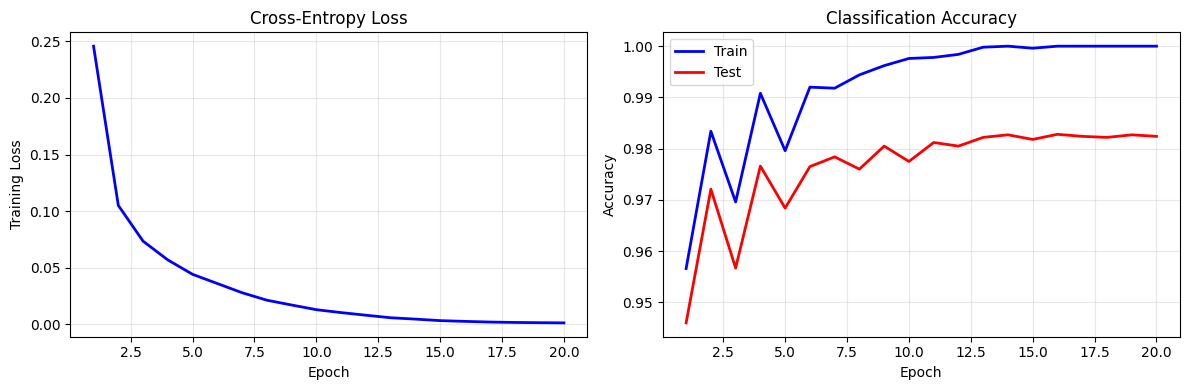


Final test accuracy: 0.9824


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Load MNIST data (simplified - using sklearn's fetch_openml)
# ============================================================
def load_mnist():
    """Load MNIST dataset."""
    try:
        from sklearn.datasets import fetch_openml
        mnist = fetch_openml('mnist_784', version=1, as_frame=False)
        X, y = mnist.data, mnist.target.astype(int)
    except:
        # Fallback: generate synthetic data for demonstration
        print("Generating synthetic data (MNIST not available)")
        np.random.seed(42)
        n_samples = 10000
        X = np.random.randn(n_samples, 784)
        y = np.random.randint(0, 10, n_samples)

    # Normalize to [0, 1]
    X = X / 255.0

    # Train/test split
    n_train = 60000 if len(X) >= 70000 else int(0.85 * len(X))
    X_train, X_test = X[:n_train], X[n_train:]
    y_train, y_test = y[:n_train], y[n_train:]

    return X_train, y_train, X_test, y_test

# ============================================================
# Neural Network Implementation
# ============================================================
class MLP:
    """Multilayer Perceptron with one hidden layer."""

    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        # Xavier initialization
        self.W1 = np.random.randn(hidden_dim, input_dim) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(output_dim, hidden_dim) * np.sqrt(2.0 / hidden_dim)
        self.b2 = np.zeros(output_dim)

        # For storing intermediate values during forward pass
        self.cache = {}

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def softmax(self, z):
        # Numerically stable softmax
        z_shifted = z - np.max(z, axis=-1, keepdims=True)
        exp_z = np.exp(z_shifted)
        return exp_z / np.sum(exp_z, axis=-1, keepdims=True)

    def forward(self, X):
        """Forward pass. X shape: (batch_size, 784)"""
        # First layer
        z1 = X @ self.W1.T + self.b1 # (batch, hidden)
        h1 = self.relu(z1)

        # Second layer
        z2 = h1 @ self.W2.T + self.b2 # (batch, 10)
        p = self.softmax(z2)

        # Cache for backward pass
        self.cache = {'X': X, 'z1': z1, 'h1': h1, 'z2': z2, 'p': p}

        return p

    def compute_loss(self, p, y):
        """Cross-entropy loss."""
        batch_size = len(y)
        # Clip for numerical stability
        p_clipped = np.clip(p, 1e-10, 1 - 1e-10)
        loss = -np.mean(np.log(p_clipped[np.arange(batch_size), y]))
        return loss

    def backward(self, y):
        """Backward pass (backpropagation)."""
        batch_size = len(y)
        X, z1, h1, z2, p = (self.cache['X'], self.cache['z1'],
                            self.cache['h1'], self.cache['z2'], self.cache['p'])

        # Output layer gradient: d_loss/d_z2 = p - one_hot(y)
        one_hot_y = np.zeros_like(p)
        one_hot_y[np.arange(batch_size), y] = 1
        delta2 = (p - one_hot_y) / batch_size # (batch, 10)

        # Gradients for W2, b2
        grad_W2 = delta2.T @ h1 # (10, hidden)
        grad_b2 = np.sum(delta2, axis=0) # (10,)

        # Backpropagate to hidden layer
        delta1 = (delta2 @ self.W2) * self.relu_derivative(z1) # (batch, hidden)

        # Gradients for W1, b1
        grad_W1 = delta1.T @ X # (hidden, 784)
        grad_b1 = np.sum(delta1, axis=0) # (hidden,)

        return {'W1': grad_W1, 'b1': grad_b1, 'W2': grad_W2, 'b2': grad_b2}

    def update(self, grads, lr):
        """SGD update."""
        self.W1 -= lr * grads['W1']
        self.b1 -= lr * grads['b1']
        self.W2 -= lr * grads['W2']
        self.b2 -= lr * grads['b2']

    def predict(self, X):
        """Predict class labels."""
        p = self.forward(X)
        return np.argmax(p, axis=1)

    def accuracy(self, X, y):
        """Compute classification accuracy."""
        predictions = self.predict(X)
        return np.mean(predictions == y)

def train_mlp(X_train, y_train, X_test, y_test, hidden_dim=128, lr=0.1, batch_size=64, epochs=20):
    """Train MLP with SGD."""

    model = MLP(hidden_dim=hidden_dim)
    n_train = len(X_train)

    history = {
    'train_loss': [], 'train_acc': [],
    'test_acc': [], 'epoch': []
    }

    for epoch in range(epochs):
        # Shuffle training data
        perm = np.random.permutation(n_train)
        X_shuffled = X_train[perm]
        y_shuffled = y_train[perm]

        epoch_loss = 0
        n_batches = 0

        # Mini-batch SGD
        for start in range(0, n_train, batch_size):
            end = min(start + batch_size, n_train)
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]

            # Forward pass
            p = model.forward(X_batch)
            loss = model.compute_loss(p, y_batch)
            epoch_loss += loss
            n_batches += 1

            # Backward pass
            grads = model.backward(y_batch)

            # SGD update
            model.update(grads, lr)

        # Record metrics
        train_loss = epoch_loss / n_batches
        train_acc = model.accuracy(X_train[:5000], y_train[:5000]) # Subsample for speed
        test_acc = model.accuracy(X_test, y_test)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['epoch'].append(epoch + 1)

        print(f"Epoch {epoch+1:2d}: Loss={train_loss:.4f}, "f"Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}")

    return model, history

def visualize_training(history):
    """Plot training curves."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    axes[0].plot(history['epoch'], history['train_loss'], 'b-', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Training Loss')
    axes[0].set_title('Cross-Entropy Loss')
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(history['epoch'], history['train_acc'], 'b-', linewidth=2, label='Train')
    axes[1].plot(history['epoch'], history['test_acc'], 'r-', linewidth=2, label='Test')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Classification Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('mnist_training.pdf', bbox_inches='tight')
    plt.show()

# Main execution
if __name__ == "__main__":
    print("Loading MNIST...")
    X_train, y_train, X_test, y_test = load_mnist()
    print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

    print("\nTraining MLP with SGD...")
    model, history = train_mlp(X_train, y_train, X_test, y_test, hidden_dim=128, lr=0.5, batch_size=64, epochs=20)

    visualize_training(history)

    print(f"\nFinal test accuracy: {history['test_acc'][-1]:.4f}")